En faisant le produit avec la matrice adaptative si jamais un pays se retrouve seul dans une classe, toute la colonne de cette classe se retrouve à zéro.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from adjency_matrix import AdaptativeMatrix, DTW,AgeReduction
from gt_a_model import GCNLayer, GCNMultiLayer, Encoder, EncoderLayer

In [2]:
AM = AdaptativeMatrix()
dtw = DTW()
AR = AgeReduction()

In [3]:
def adjency_matrix(X: torch.Tensor, coord_countries: torch.Tensor):
    """
    X is 3D tensor of mortality rates
    coord_countries is 2D matrix contains longitude and latitude of each country. 1st column represents long and 2nd represents lat
    """
    n_countries  = X.shape[0]
    clusters = AM.adaptative_matrix(X)
    dtw_matrix = dtw.DTW_Matrix(X)
    long_lat_matrix = np.empty((n_countries, n_countries))
    for i in range(n_countries):
        for j in range(n_countries):
            long_lat_matrix[i,j] = torch.sqrt(torch.mean((coord_countries[i]-coord_countries[j])**2))
    
    # 
    adjency_mat = dtw_matrix * long_lat_matrix
    #print("adj_brut_matrix \n",adjency_mat)
    for i in range(n_countries):
        for j in range(n_countries):
            if clusters[i] != clusters[j]:
                adjency_mat[i,j] = 0.005
    
    #print("long_lat \n",long_lat_matrix)
    print("clusters \n",clusters)
    return adjency_mat


### 2) Importation des données de mortalité


In [4]:
### import mortality data for the different countries
import os
 
directory = '/Users/gojelastat/Desktop/Thèse/Projet 2/Données/Données GT-A'
data={}
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and filename.endswith('.txt'):
        data[filename.split('.')[0]]=pd.read_csv(f,header=1,delimiter="\s+") ### filename.split('.')[0] split the name by . and recover the code of the country
        ### in this line, we fill the dictionary "data" with the different data of country and their code

In [5]:
columns = list(data.keys())
a_supprimer = ['AUS', 'ISL', 'NZL_NP', 'USA', 'JPN', 'BGR', 'IRL', 'CAN']
new_col = [elm for elm in columns if elm not in a_supprimer]
len(new_col)


16

### 3) Mettre les données au format adéquat 
C'est-à-dire sous forme de tenseur de taille M x T x A où M est le nombre de pays, T est la dimension du temps et A est la dimension de l'âge. Rappelons que ceci est fait pour s'adapter au cadre d'implémentation du modèle GT-A et ici on travaille avec les données des **hommes**

In [10]:
#fonction permettant de transformer les données dans la bonne numérisation
def __data_load(data,start=1950, end=2019):
    columns=data.columns
    data['Age']=np.where(data['Age']!='110+',data['Age'],111)
    for col in columns:
        data[col]=np.where(data[col]!='.',data[col],99999)
        data[col]=pd.to_numeric(data[col])

    data=data[data['Age']<=100] 
    #data=data[data['Age']>=50]
    data=data[data['Year']>=start]
    data=data[data['Year']<=end]

    #df_min=np.min(data['Male'])
    #df_max=np.max(data['Male'])

    #data['Male']=(data['Male']-df_min)/(df_max-df_min)
    data.index=np.arange(data.shape[0])  ### renommer les index de 0 jusqu'à la taille de data
    return data#,df_min,df_max


def __test_load(data,start=2001, end=2016):
    columns=data.columns
    data['Age']=np.where(data['Age']!='110+',data['Age'],111)
    for col in columns:
        data[col]=np.where(data[col]!='.',data[col],9999)
        data[col]=pd.to_numeric(data[col])

    data=data[data['Age']<100]
    #data=data[data['Age']>=50]
    data=data[data['Year']>=start]
    data=data[data['Year']<=end]

    #df_min=np.min(data['Male'])
    #df_max=np.max(data['Male'])

    #data['Male']=(data['Male']-df_min)/(df_max-df_min)
    data.index=np.arange(data.shape[0])  ### renommer les index de 0 jusqu'à la taille de data
    return data#,df_min,df_max


### Transform the based dataset to matrix of mortality rates of male people in this case. 
#The matrix has age on row and year on columns
def __data_reshaping(data,Gender="Male",start=1950, end=2019):
    data=__data_load(data,start, end)
    data[Gender] = np.where(data[Gender] != 0.0, data[Gender], 0.00000001)
    mat=pd.DataFrame(index=np.unique(data['Age']),columns=np.unique(data['Year']))
    n=0
    for j in range(mat.shape[1]):
        for i in range(mat.shape[0]):
            mat.iloc[i,j]=data.loc[n+i,Gender]
        n=n+mat.shape[0]
    years=np.arange(1950,(1950+mat.shape[1]))
    ages=np.arange(0,(mat.shape[0]))

    #for col in years:
    #    mat[col]=pd.to_numeric(mat[col])
    return np.array(mat.T, dtype=np.float32) # ici on essaie de convertir en un tableau floattant, la transposée c'est parce que le code
    # était fait pour sortir une matrice de taille A x T.


def __test_reshaping(data,Gender="Male",start=2001, end=2016):
    data=__test_load(data,start, end)
    data[Gender] = np.where(data[Gender] != 0.0, data[Gender], 0.00000001)
    mat=pd.DataFrame(index=np.unique(data['Age']),columns=np.unique(data['Year']))
    n=0
    for j in range(mat.shape[1]):
        for i in range(mat.shape[0]):
            mat.iloc[i,j]=data.loc[n+i,Gender]
        n=n+mat.shape[0]
    years=np.arange(1950,(1950+mat.shape[1]))
    ages=np.arange(0,(mat.shape[0]))

    #for col in years:
    #    mat[col]=pd.to_numeric(mat[col])
    return np.array(mat.T, dtype=np.float32) # ici on essaie de convertir en un tableau floattant, la transposée c'est parce que le code
    # était fait pour sortir une matrice de taille A x T.


In [7]:
### Search for outliers (<=0 or >=1) in male data
#for code, country in data.items():
#    print(data[code][data[code].Male <= 0])

In [11]:
### Search for outliers (<=0 or >=1) in male data
for code, country in data.items():
    print("{} minimum is {} and maximum is {}".format(code,np.min(data[code].Male), np.max(data[code].Male)))

PRT minimum is 0.0 and maximum is 9999.0
GBR_NP minimum is 0.0 and maximum is 9999.0
BEL minimum is 0.0 and maximum is 9999.0
CHE minimum is 0.0 and maximum is 9999.0
NOR minimum is 0.0 and maximum is 9999.0
AUS minimum is 0.0 and maximum is 9999.0
ESP minimum is 0.0 and maximum is 9999.0
ISL minimum is 0.0 and maximum is 9999.0
AUT minimum is 0.0 and maximum is 9999.0
NZL_NP minimum is 0.0 and maximum is 9999.0
HUN minimum is 0.0 and maximum is 9999.0
FRACNP minimum is 0.0 and maximum is 9999.0
NLD minimum is 0.0 and maximum is 9999.0
DNK minimum is 0.0 and maximum is 9999.0
USA minimum is 0.000103 and maximum is 1.150146
JPN minimum is 0.0 and maximum is 9999.0
SWE minimum is 0.0 and maximum is 9999.0
FIN minimum is 0.0 and maximum is 9999.0
CZE minimum is 0.0 and maximum is 9999.0
ITA minimum is 0.0 and maximum is 9999.0
BGR minimum is 0.0 and maximum is 9999.0
SVK minimum is 0.0 and maximum is 9999.0
IRL minimum is 0.0 and maximum is 9999.0
CAN minimum is 0.0 and maximum is 9999.0


In [9]:
from sklearn.preprocessing import MinMaxScaler

### Analyse des données

In [7]:
data.keys()

dict_keys(['PRT', 'GBR_NP', 'BEL', 'CHE', 'NOR', 'AUS', 'ESP', 'ISL', 'AUT', 'NZL_NP', 'HUN', 'FRACNP', 'NLD', 'DNK', 'USA', 'JPN', 'SWE', 'FIN', 'CZE', 'ITA', 'BGR', 'SVK', 'IRL', 'CAN'])

In [12]:
T = 2016 - 1950 + 1
A = 100 - 0 + 1
df = torch.FloatTensor(len(data.keys()), T, A)
df_log = torch.FloatTensor(len(data.keys()), T, A)
for i,country in enumerate(data.keys()):
    df[i] = torch.tensor(__data_reshaping(data[country],start=1950, end=2016))
    df_log[i] = torch.log(df[i])

In [13]:
df_log.isnan().sum()

tensor(0)

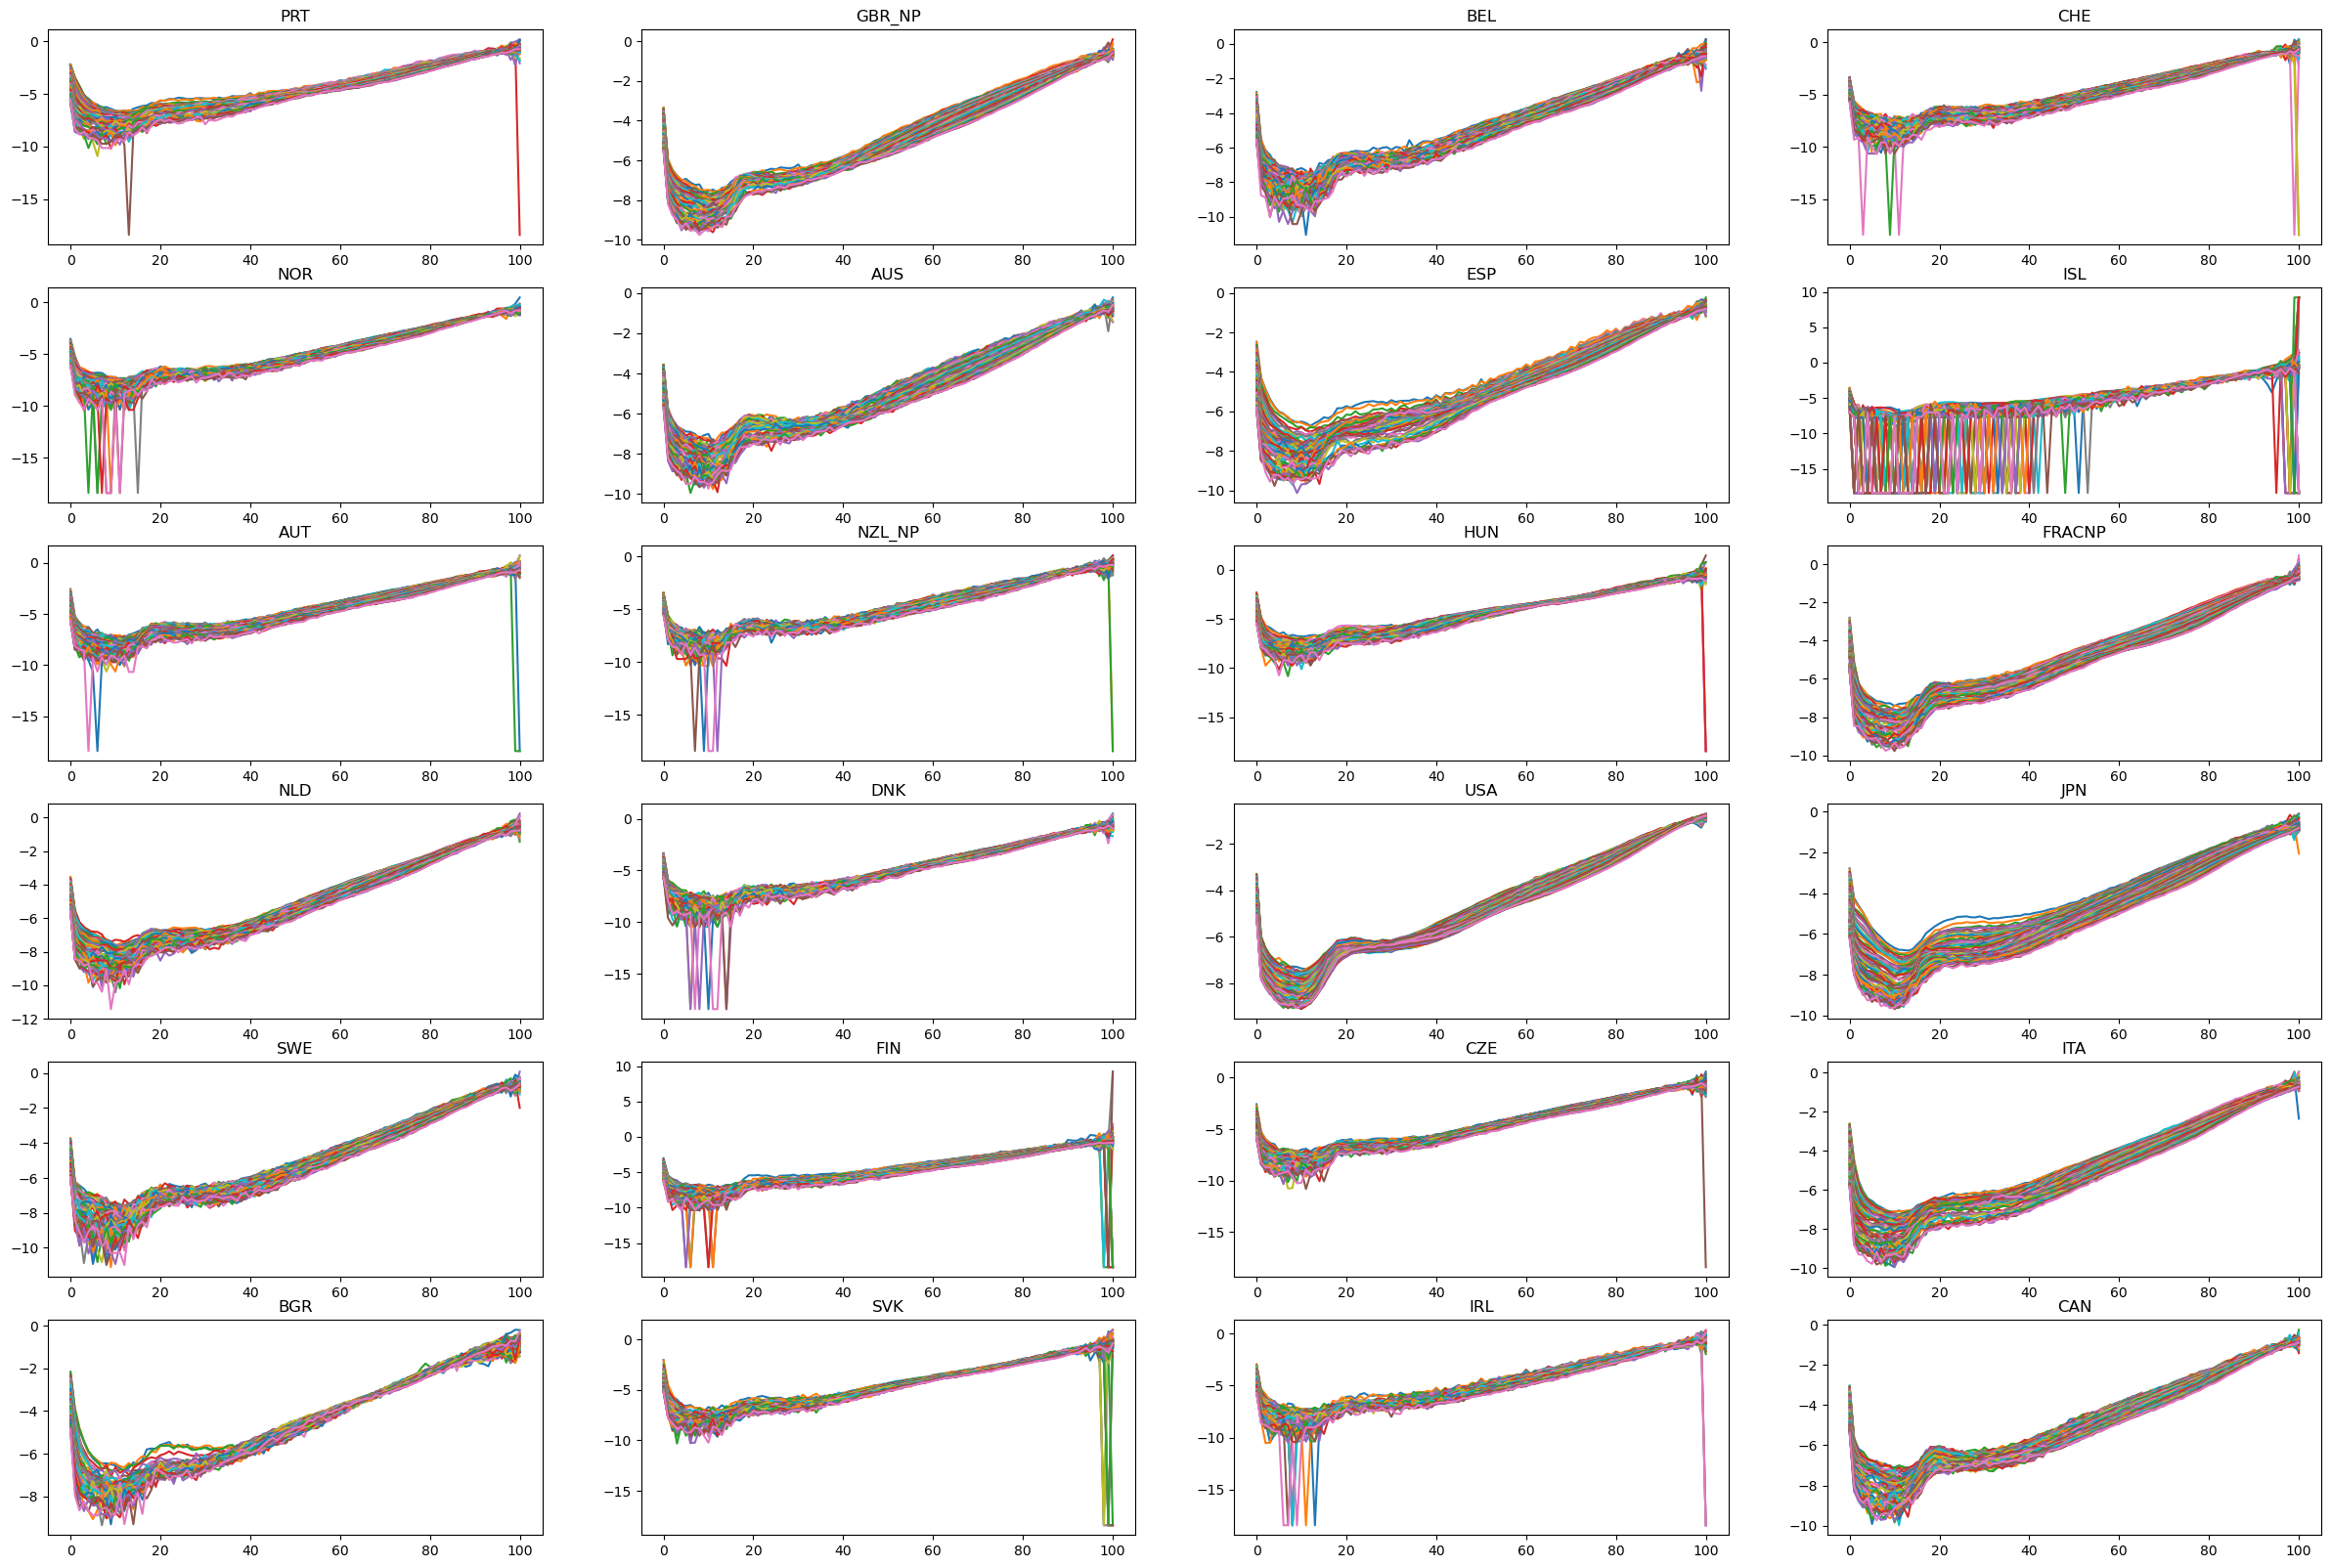

In [14]:
# Initialisation de la figure et des subplots
n_subplots = len(data.keys())  # Nombre de subplots
fig, axs = plt.subplots(6, 4, figsize=(30, 20))  # 2 lignes, 2 colonnes

# Boucle sur chaque subplot
for i in range(n_subplots):
    row = i // 4  # Calcul de l'index de ligne
    col = i % 4   # Calcul de l'index de colonne

    df1 = pd.DataFrame(df_log[i].T)
    axs[row,col].plot(df1)
    axs[row,col].set_title(list(data.keys())[i])

In [15]:
# Remplacer toutes les log_mortalité inférieures à -15 et supérieures à 0 par nan 
df_log = torch.where((df_log > -15) & (df_log < 0), df_log, torch.tensor(float('nan')))
new_col = ['PRT','GBR_NP','BEL','CHE','NOR','ESP','AUT','HUN','FRACNP','NLD','DNK','SWE','FIN','CZE','ITA','SVK']
data_col = list(data.keys())
index_new_col = [data_col.index(elem) for elem in new_col]

# Remplacer les nan par la moyenne des log_mortalité des pays sans nan
for i in range(df_log.shape[0]):
    for j in range(df_log.shape[1]):
        for k in range(df_log.shape[2]):
            if torch.isnan(df_log[i,j,k]):
                df_log[i,j,k] = torch.nanmean(df_log[index_new_col,j,k])


# Normalisation de df
df_norm = torch.FloatTensor(df_log.shape)
sc = []
for i in range(df_log.shape[0]):
    m = StandardScaler()
    norm = torch.FloatTensor(m.fit_transform(df_log[i]))
    df_norm[i] = norm
    sc.append(m)

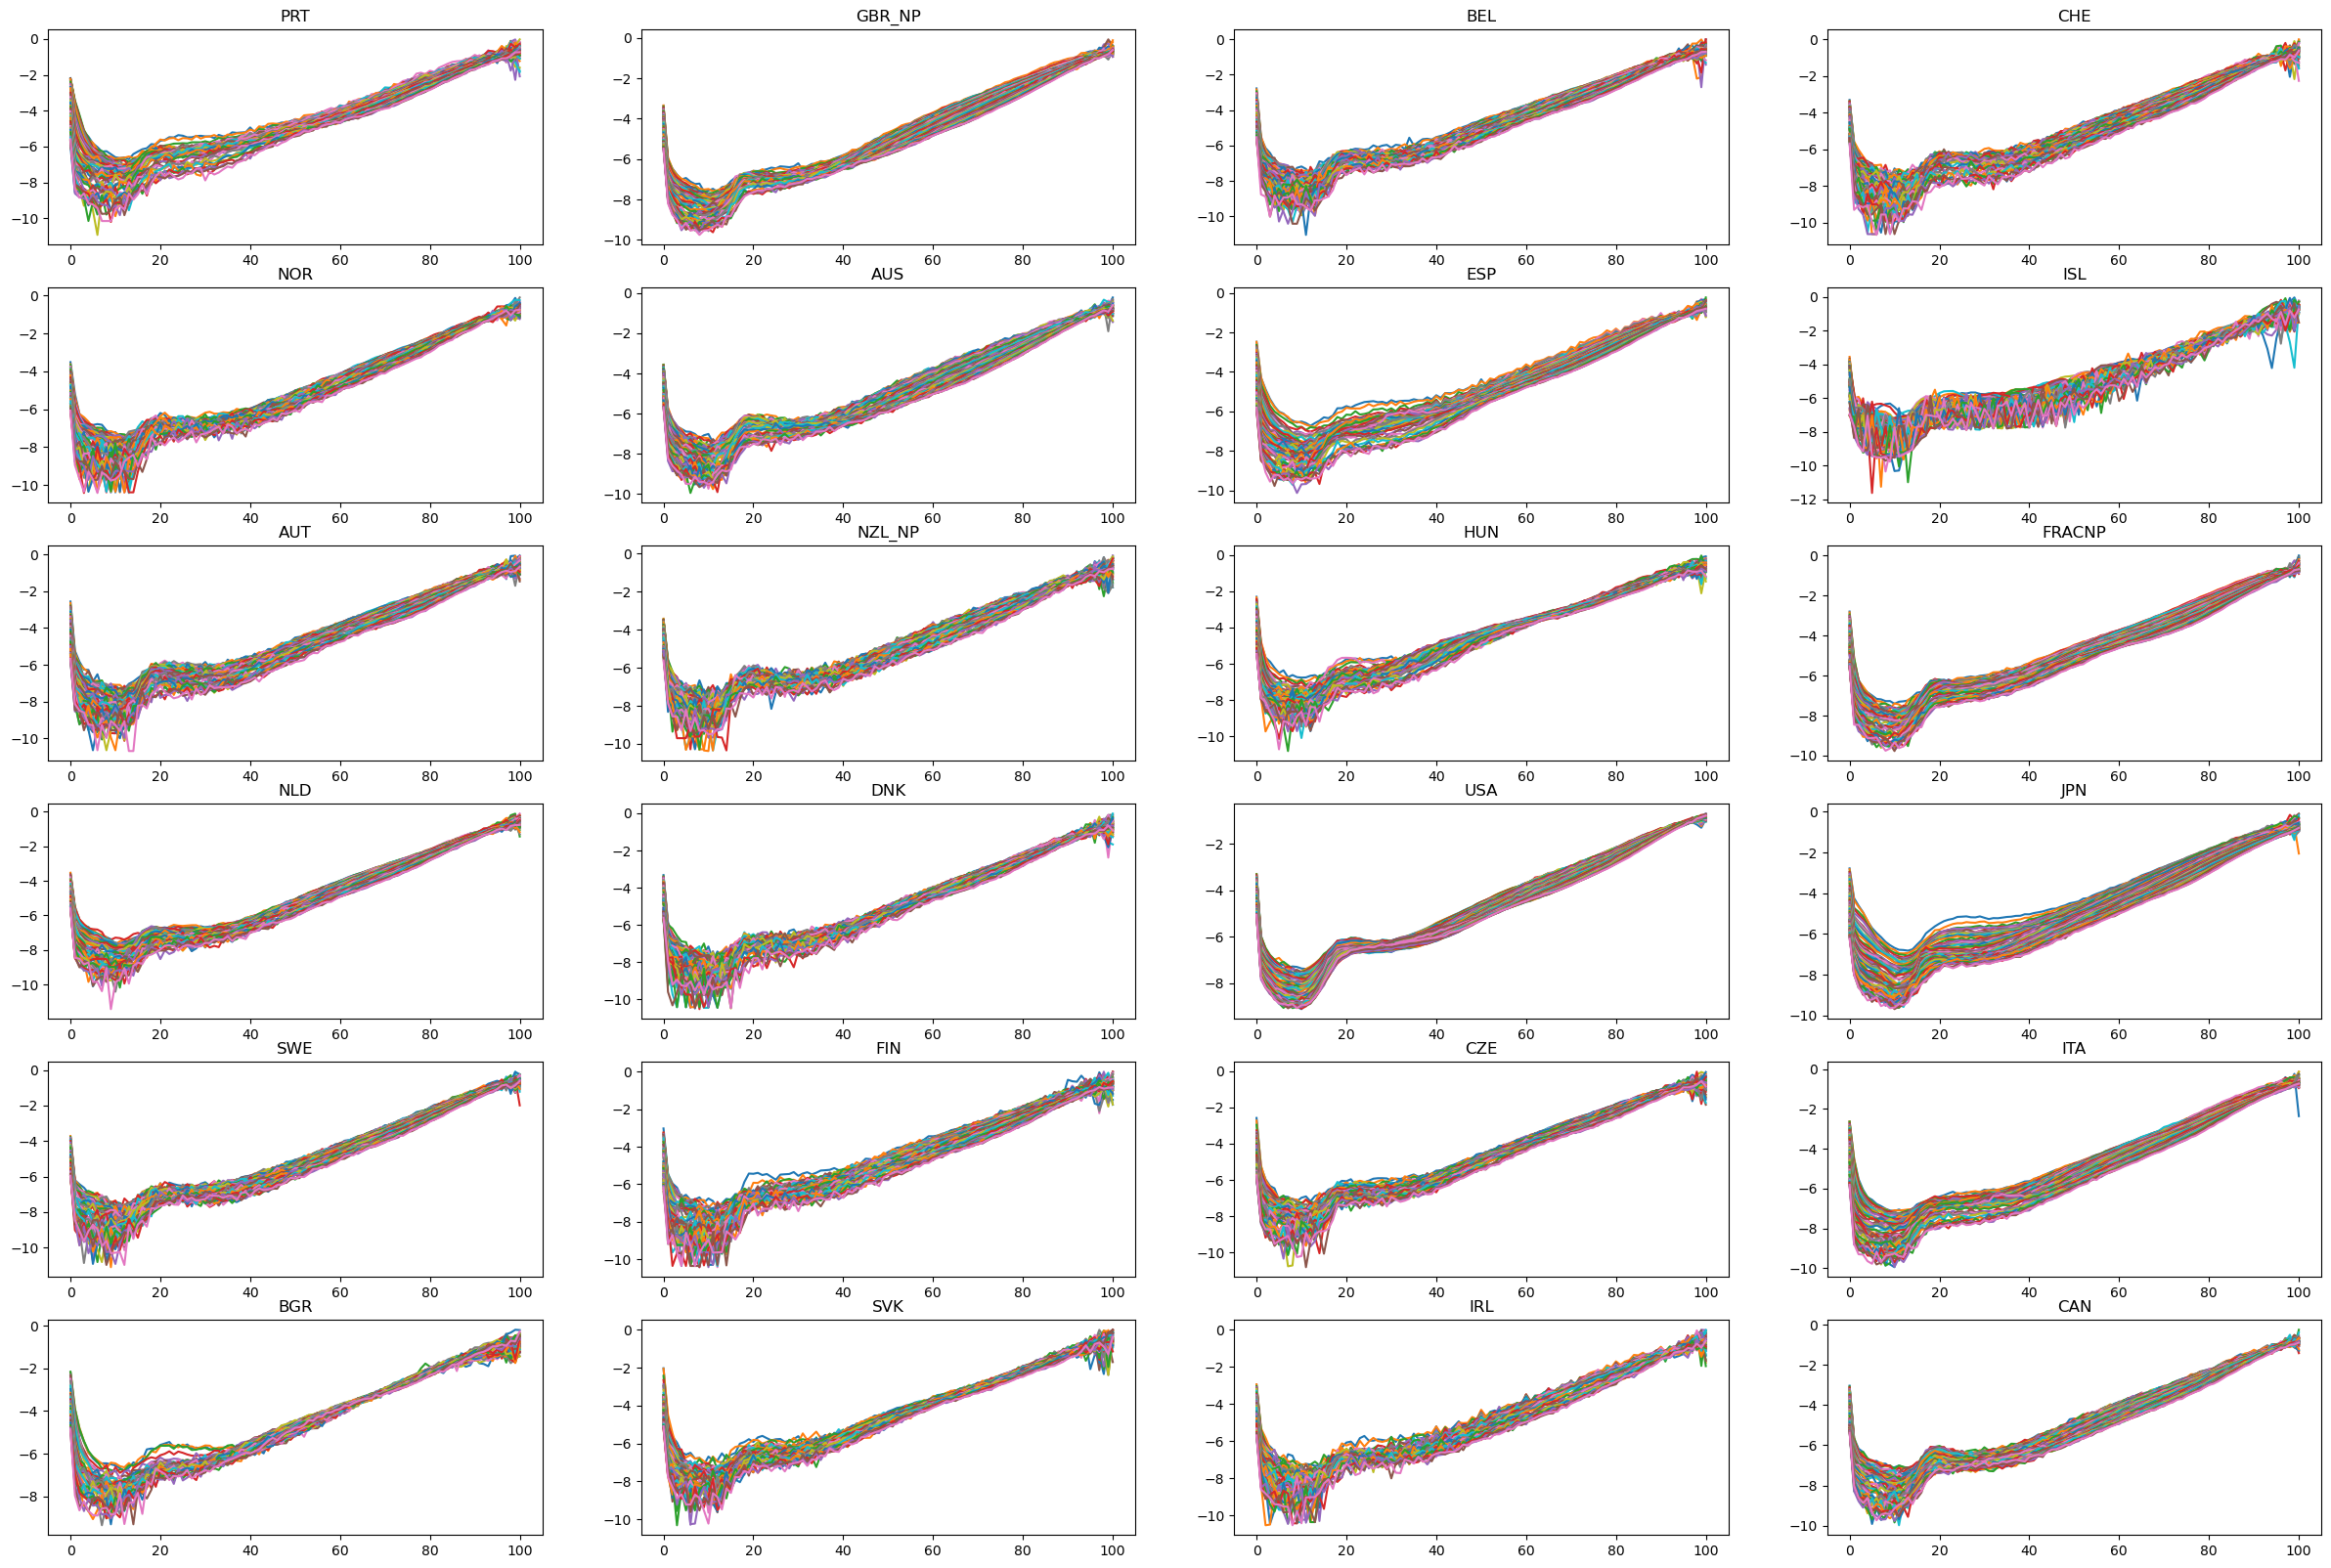

In [16]:
# Initialisation de la figure et des subplots
n_subplots = len(data.keys())  # Nombre de subplots
fig, axs = plt.subplots(6, 4, figsize=(30, 20))  # 2 lignes, 2 colonnes

# Boucle sur chaque subplot
for i in range(n_subplots):
    row = i // 4  # Calcul de l'index de ligne
    col = i % 4   # Calcul de l'index de colonne

    df1 = pd.DataFrame(df_log[i].T)
    axs[row,col].plot(df1)
    axs[row,col].set_title(list(data.keys())[i])

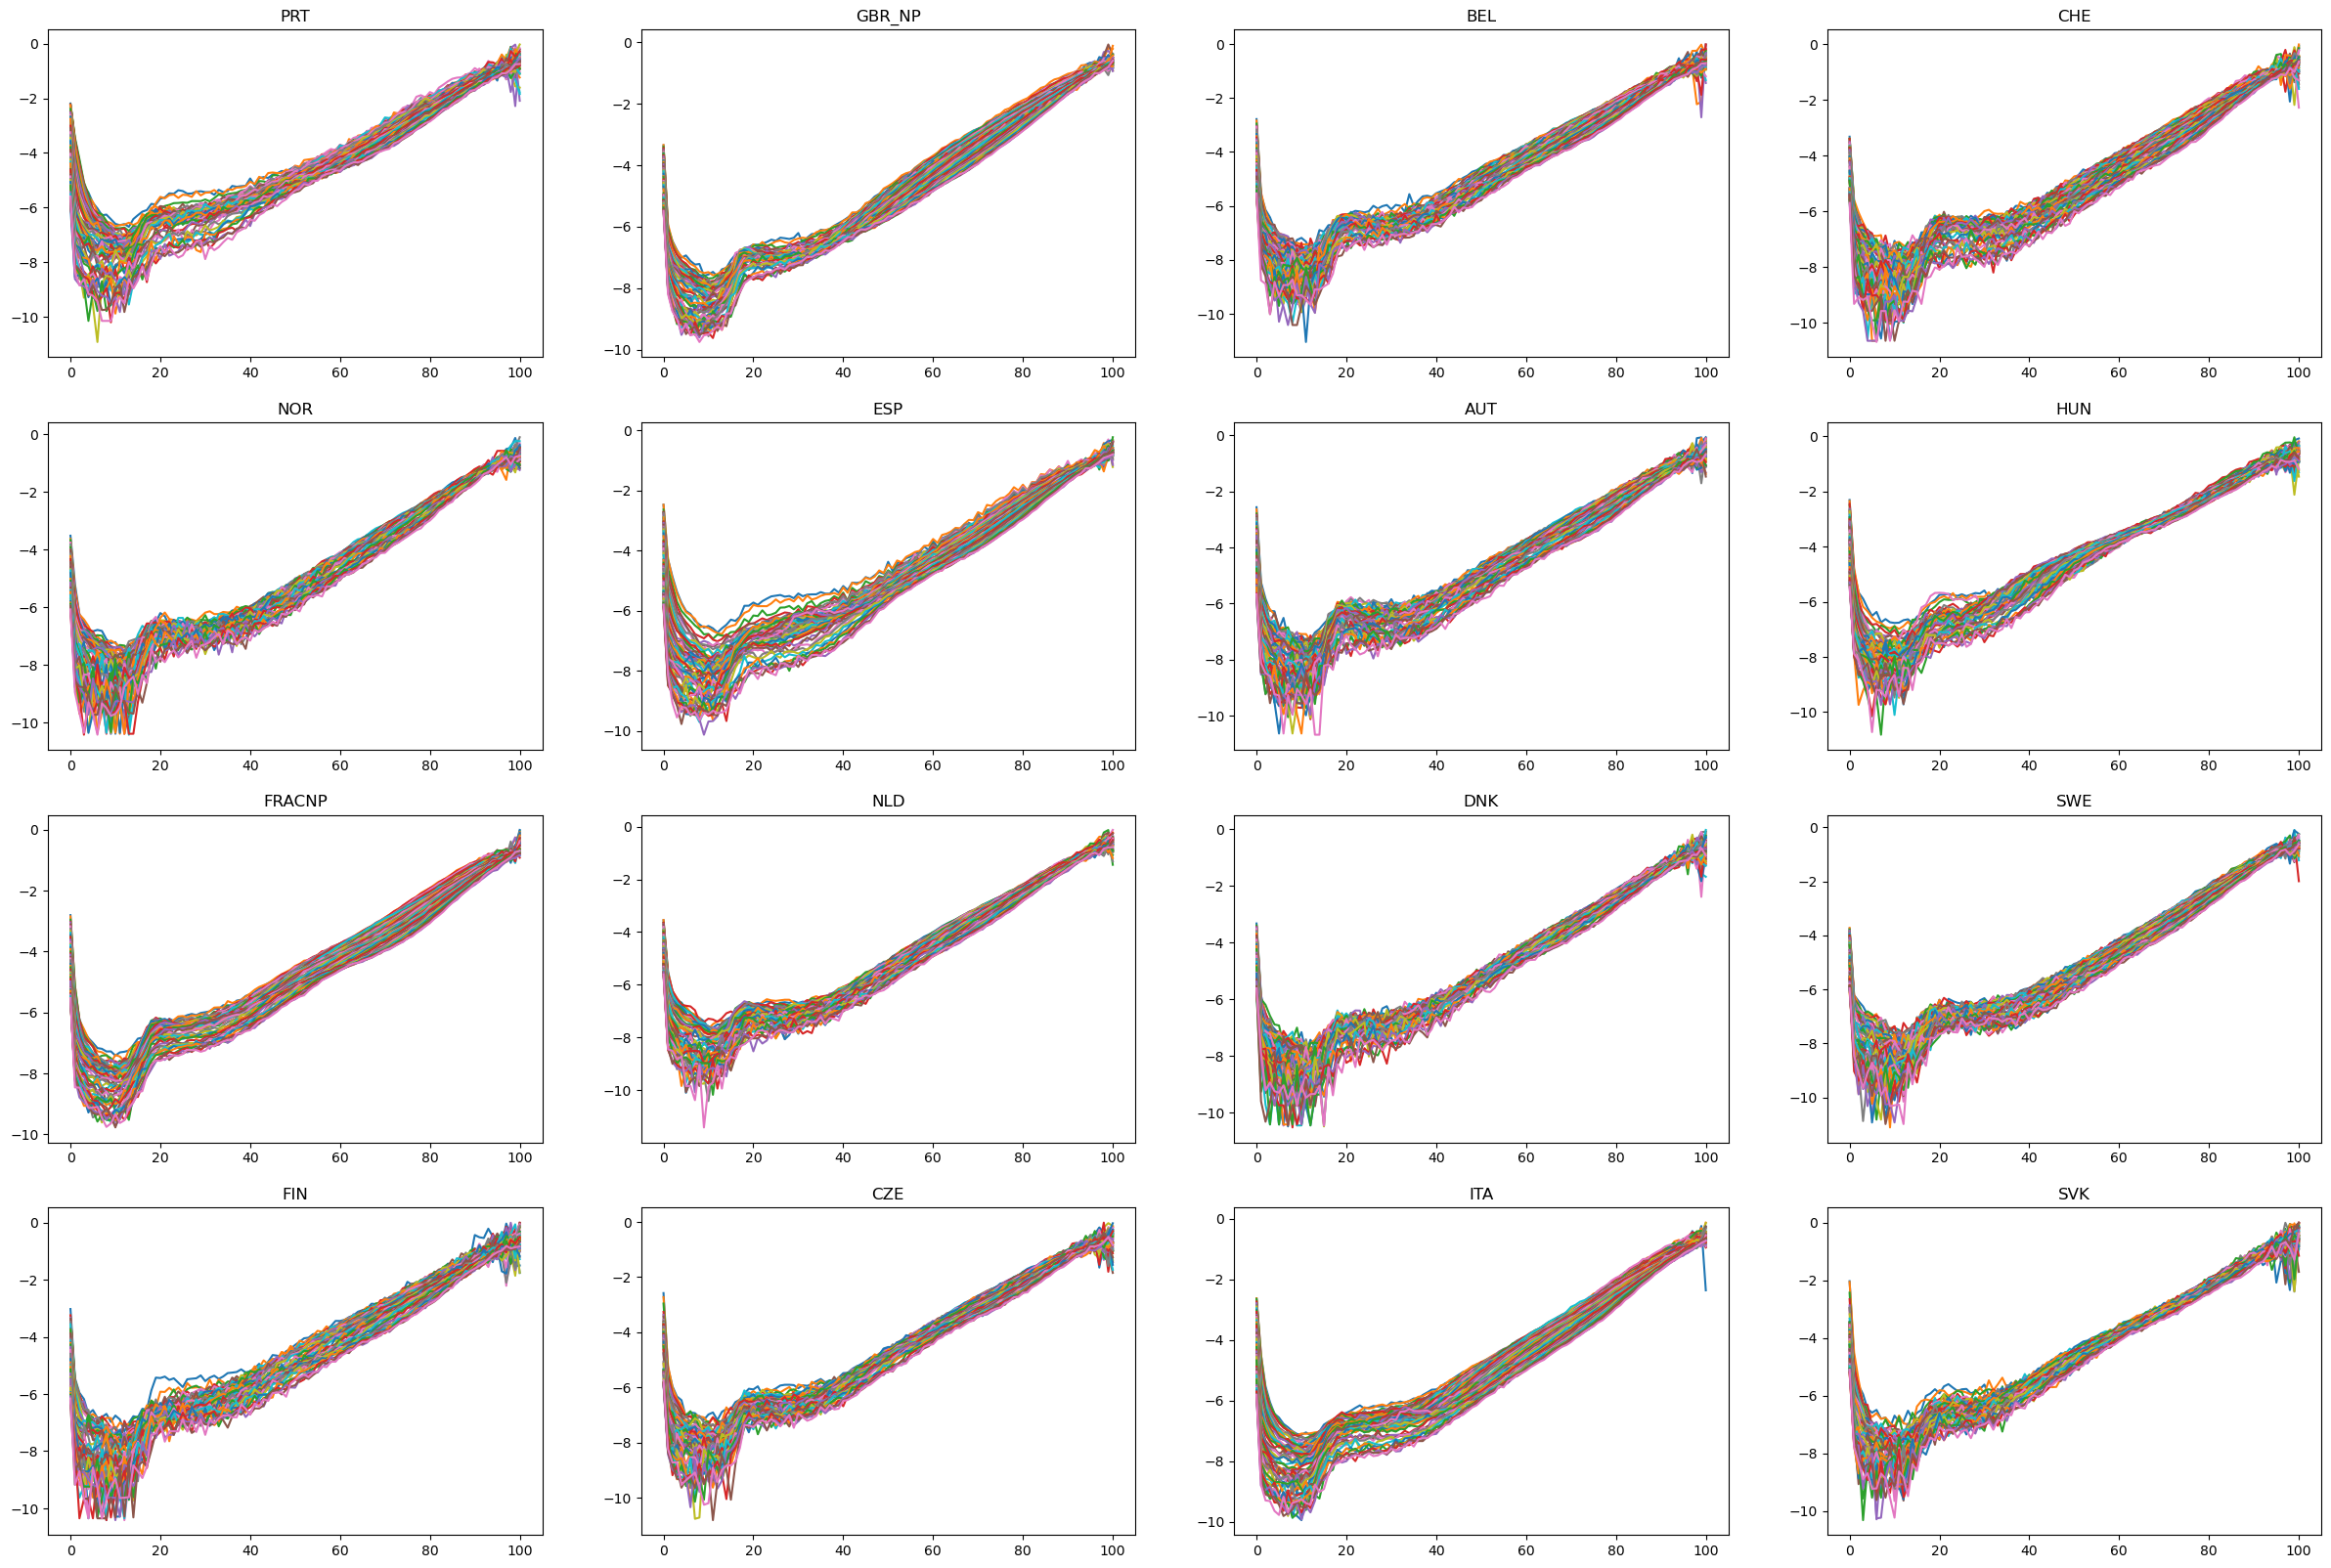

In [17]:
# Initialisation de la figure et des subplots
n_subplots = len(new_col)  # Nombre de subplots
fig, axs = plt.subplots(4, 4, figsize=(30, 20))  # 2 lignes, 2 colonnes

# Boucle sur chaque subplot
for i,ind_col in enumerate(index_new_col):
    row = i // 4  # Calcul de l'index de ligne
    col = i % 4   # Calcul de l'index de colonne

    df1 = pd.DataFrame(df_log[ind_col].T)
    axs[row,col].plot(df1)
    axs[row,col].set_title(new_col[i])

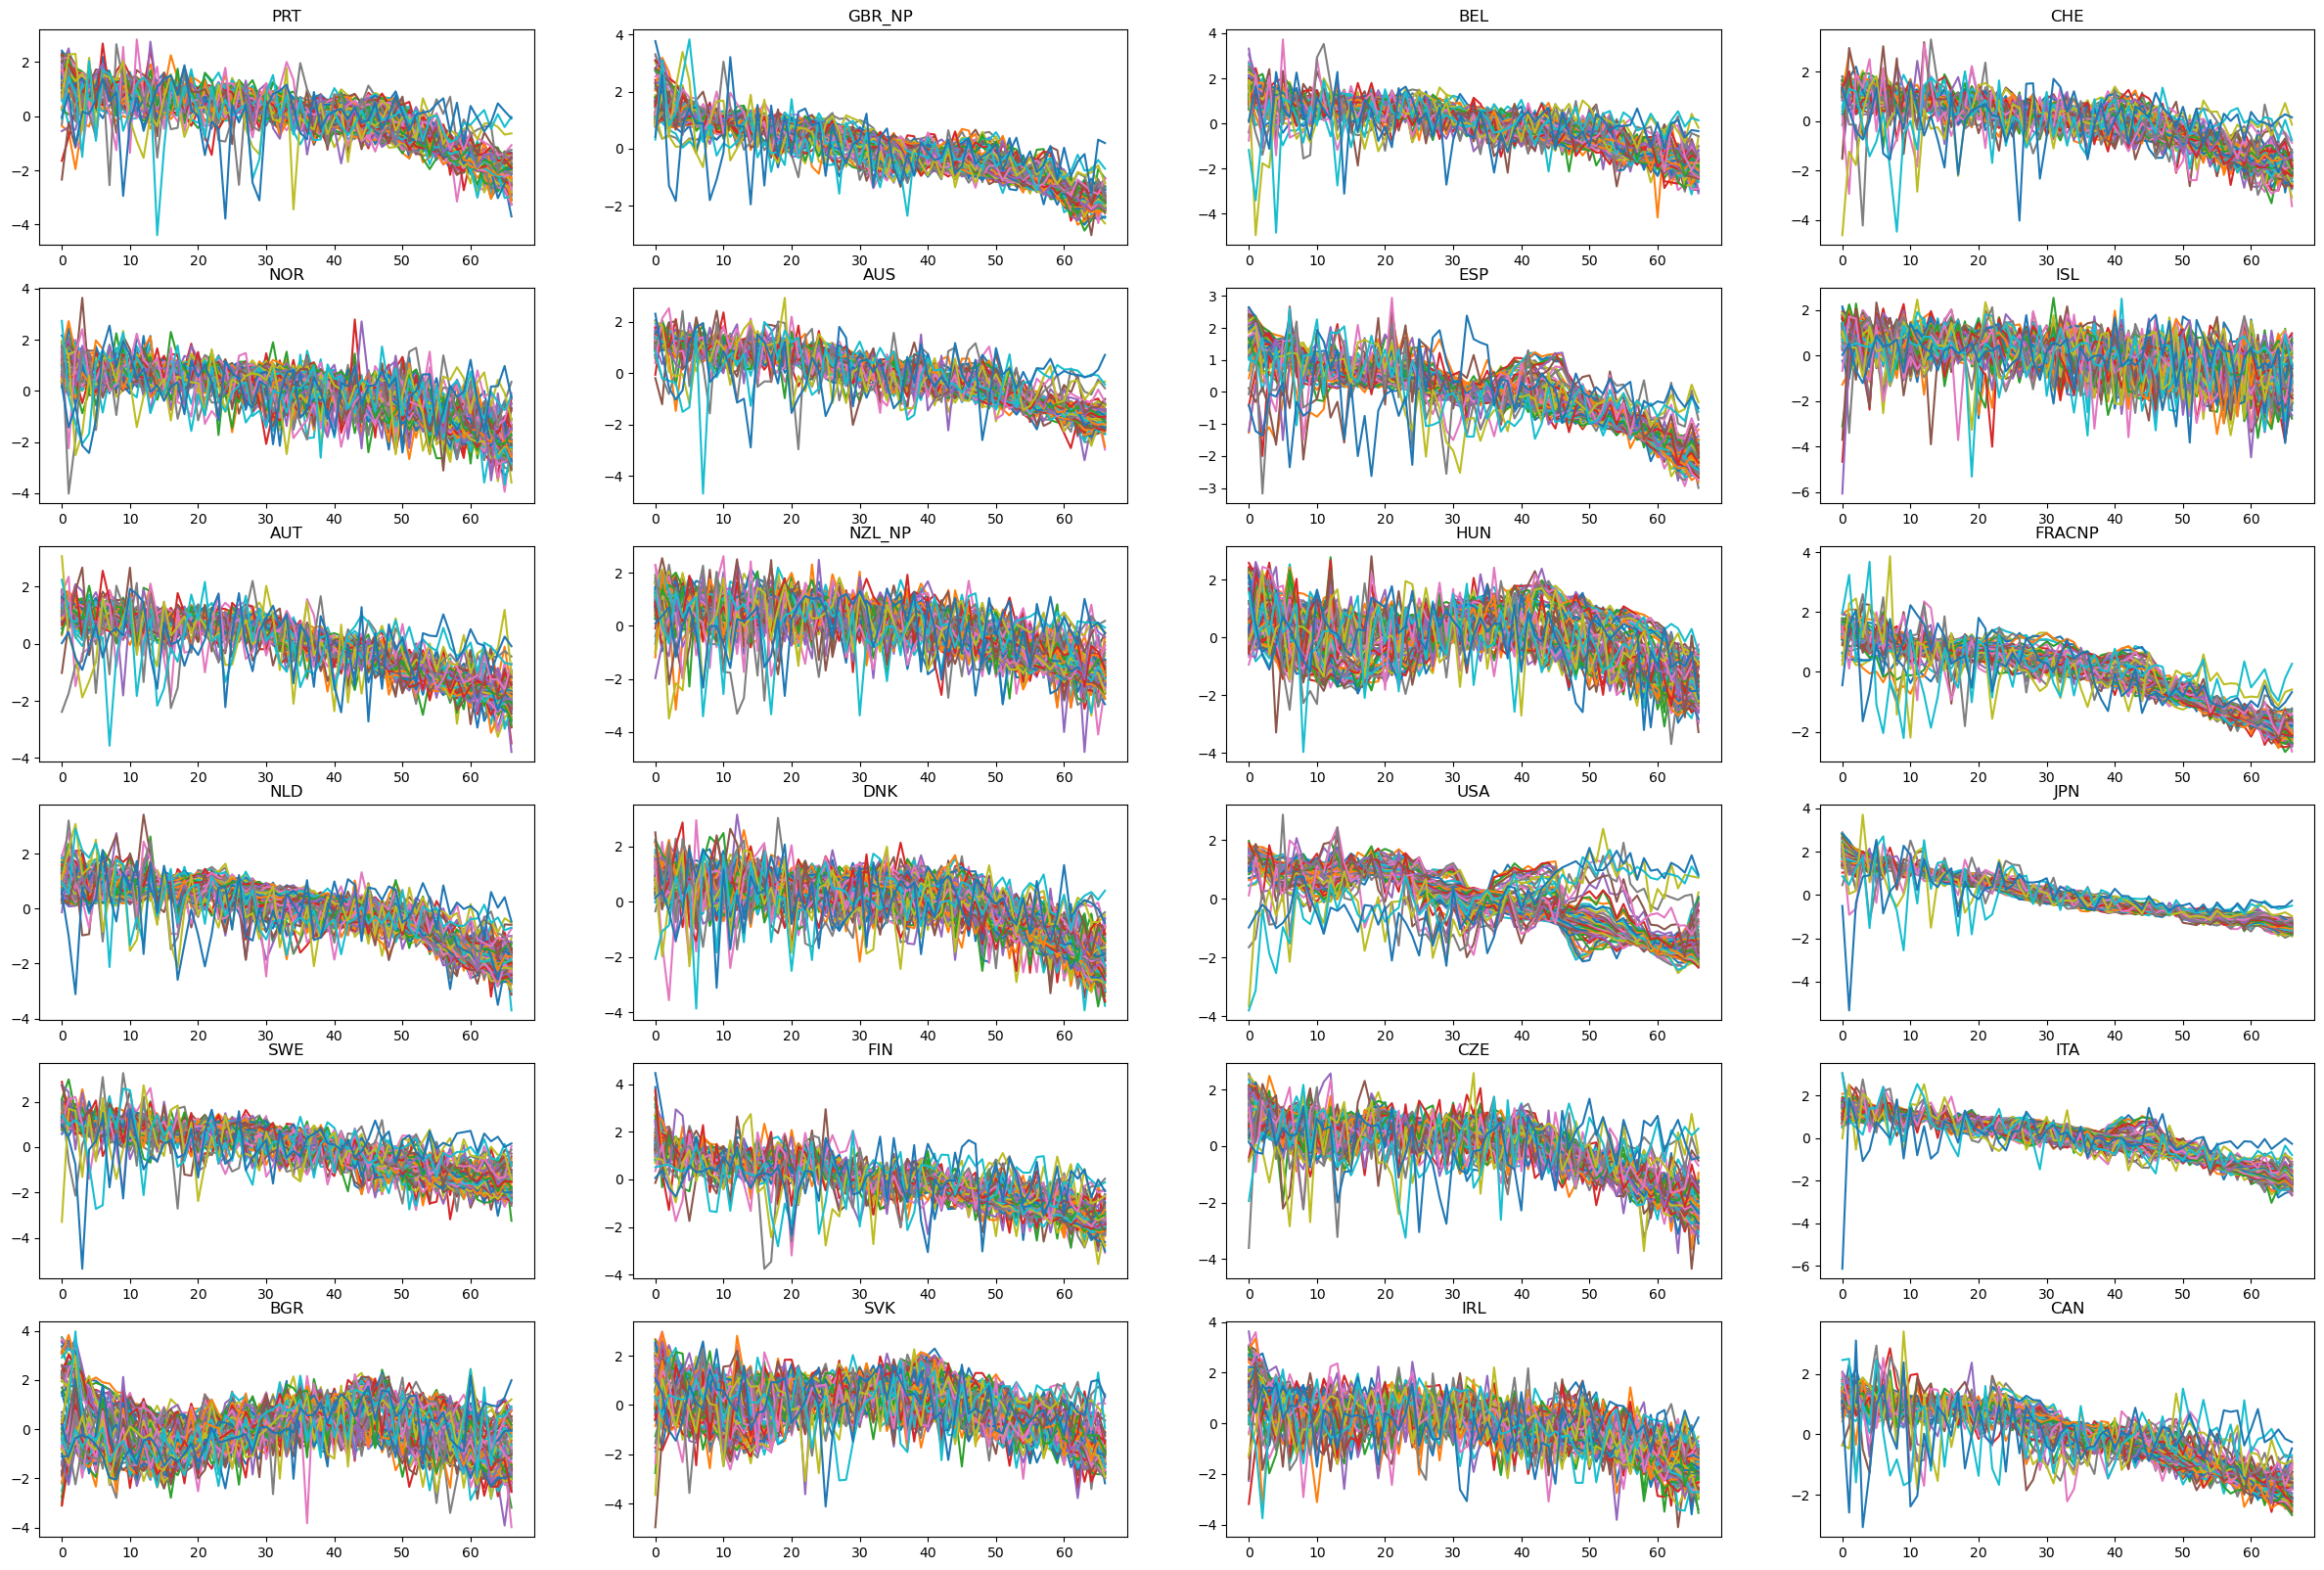

In [318]:
# Initialisation de la figure et des subplots
n_subplots = len(data.keys())  # Nombre de subplots
fig, axs = plt.subplots(6, 4, figsize=(30, 20))  # 2 lignes, 2 colonnes

# Boucle sur chaque subplot
for i in range(n_subplots):
    row = i // 4  # Calcul de l'index de ligne
    col = i % 4   # Calcul de l'index de colonne

    df1 = pd.DataFrame(df_norm[i])
    axs[row,col].plot(df1)
    axs[row,col].set_title(list(data.keys())[i])

In [300]:
# Récupération des données de test et d'entrainement 

T = 2000 - 1950 + 1
A = 100 - 0 + 1
T2 = 2019-2001 + 1
new_col = ['PRT','GBR_NP','BEL','CHE','NOR','ESP','AUT','HUN','FRACNP','NLD','DNK','SWE','FIN','CZE','ITA','SVK']
data_col = list(data.keys())
index_new_col = [data_col.index(elem) for elem in new_col]
X = torch.FloatTensor(len(new_col), T, A)

X = df_log[index_new_col,0:T,:]
test = df_log[index_new_col,(T):(T+T2),:]
X_norm =  df_norm[index_new_col,0:T,:]


In [319]:
df_log.isnan().sum()

tensor(0)

70

In [121]:
X.shape

torch.Size([16, 67, 100])

Comment faire la normalisation pour chaque pays et pouvoir récupérer la normalisation pour l'inversion par la suite

#### Coordonnées géographique des pays 
Ici on oriente le globe en un repère orthonormé avec l'axe des abscisses orienté vers l'Est et l'axe des ordonnées orienté vers le Nord. Ces coordonnées ont été pris sur wikipédia. Dans la base de données HMD, il y a la base de données par régions du UK et pour toute la population UK. On a choisi d'utiliser la base du UK total.

In [122]:
new_col

['PRT',
 'GBR_NP',
 'BEL',
 'CHE',
 'NOR',
 'ESP',
 'AUT',
 'HUN',
 'FRACNP',
 'NLD',
 'DNK',
 'SWE',
 'FIN',
 'CZE',
 'ITA',
 'SVK']

In [114]:

country = ['AUT','GBR_NP', 'HUN', 'DNK',
           'SWE', 'FIN', 'CZE', 'SVK', 'PRT', 'BEL', 'ESP',
           'FRACNP', 'NLD', 'ITA', 'CHE', 'NOR']



coord = np.array([[47.20, 13.20], [54.00, -2.30],
                  [47.00, 20.00], [56.00, 10.00],
                  [62.00, 15.00], [64.00, 26.00], [49.00, 15.00],
                  [48.40, 19.30], [53.00, -8.00], [60.00, -95.00],
                   [40.00, -4.00], [47.00, 2.00], 
                 [51.55, 5.34], [42.5001, 12.5001], [47.00, 8.00], [62.00, 10.00]])

geo_coord = pd.DataFrame(coord, index=country, columns=['Latitude', 'Longitude'])
geo_coord = geo_coord.loc[new_col]
geo_coord

Latitude  Longitude
PRT      53.0000    -8.0000
GBR_NP   54.0000    -2.3000
BEL      60.0000   -95.0000
CHE      47.0000     8.0000
NOR      62.0000    10.0000
ESP      40.0000    -4.0000
AUT      47.2000    13.2000
HUN      47.0000    20.0000
FRACNP   47.0000     2.0000
NLD      51.5500     5.3400
DNK      56.0000    10.0000
SWE      62.0000    15.0000
FIN      64.0000    26.0000
CZE      49.0000    15.0000
ITA      42.5001    12.5001
SVK      48.4000    19.3000

### 4) Calcul de la matrice $A_{lat-long}$

In [115]:
n_countries = len(new_col)
A_lat_long = torch.FloatTensor(n_countries, n_countries)
for i, country_1 in enumerate(new_col):
    for j, country_2 in enumerate(new_col):
        A_lat_long[i,j] = np.sqrt(np.mean((geo_coord.loc[country_1]-geo_coord.loc[country_2])**2))

A_lat_long[1:4,1:4]

tensor([[ 0.0000, 65.6860,  8.8060],
        [65.6860,  0.0000, 73.4098],
        [ 8.8060, 73.4098,  0.0000]])

In [80]:
# Cette partie permet de convertir le dataframe en numpy floattant
geo_coord = torch.FloatTensor(np.array(geo_coord, dtype=np.float32))

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data

In [305]:
X_red = AR.age_reduction(df_log,n_components=4)

The variance explained by principal components:  [0.87860031 0.05096693 0.01273561 0.00704964]
The variance explained by principal components:  [0.94092519 0.01943491 0.01261913 0.00322256]
The variance explained by principal components:  [0.85015299 0.02973245 0.01364975 0.01212133]
The variance explained by principal components:  [0.85808102 0.02768234 0.01079782 0.00992196]
The variance explained by principal components:  [0.78028408 0.04537574 0.01877491 0.01721906]
The variance explained by principal components:  [0.92407012 0.01613652 0.01039471 0.00437817]
The variance explained by principal components:  [0.91596206 0.04506971 0.01020032 0.00572304]
The variance explained by principal components:  [0.48571748 0.03831062 0.03360796 0.03060106]
The variance explained by principal components:  [0.87538254 0.02754959 0.00929269 0.00843938]
The variance explained by principal components:  [0.7589118  0.02864221 0.02043713 0.01566878]
The variance explained by principal components:  [

ValueError: cannot reshape array of size 6720 into shape (24,70)

In [47]:
X_red = pd.DataFrame(X_red.T, columns=data.keys())

In [41]:
data.keys()

dict_keys(['PRT', 'GBR_NP', 'BEL', 'AUS', 'ESP', 'ISL', 'AUT', 'NZL_NP', 'HUN', 'FRACNP', 'NLD', 'DNK', 'USA', 'JPN', 'SWE', 'FIN', 'CZE', 'ITA', 'BGR', 'SVK', 'IRL', 'CAN'])

In [48]:
X_red

PRT    GBR_NP       BEL       AUS       ESP       ISL       AUT  \
0   3.934631  4.357734  3.865911  3.574754  5.188376  3.100202  3.517454   
1   4.200491  4.784065  3.716747  4.110461  5.677650  2.140823  3.665743   
2   2.898273  3.481108  2.649397  3.627137  3.302301  1.732603  2.700925   
3   2.319487  3.063850  2.706628  3.116458  3.089121  2.307670  2.341107   
4   2.452903  2.882614  2.368883  3.019600  2.397818  1.525630  2.569147   
..       ...       ...       ...       ...       ...       ...       ...   
56 -3.259055 -3.714148 -3.807220 -4.141756 -2.781474 -2.136452 -4.114341   
57 -3.466871 -3.828822 -3.927810 -4.113325 -2.789204 -2.247274 -4.227517   
58 -3.613147 -3.894572 -3.932001 -4.202505 -2.962699 -2.504712 -4.390377   
59 -3.764745 -4.174509 -4.171230 -4.336475 -3.165016 -2.261217 -4.277094   
60 -3.810557 -4.411011 -4.293502 -4.516204 -3.325600 -2.221711 -4.425826   

      NZL_NP       HUN    FRACNP  ...       USA       JPN       SWE       FIN  \
0   2.388937 -1.755937  4.240668  ...  4.070866  6.337208  3.723130  4.723927   
1   2.665622 -2.048462  4.603405  ...  4.024963  5.090863  3.474737  3.756699   
2   2.325179 -1.916504  3.537219  ...  3.772994  4.205085  3.037368  3.061535   
3   1.756380 -2.262414  4.020613  ...  3.559877  4.607428  3.136420  3.101511   
4   1.791565 -1.900540  3.127559  ...  2.584128  3.780058  2.421719  2.474127   
..       ...       ...       ...  ...       ...       ...       ...       ...   
56 -3.681134  1.099329 -4.105382  ... -4.024142 -2.899369 -3.988284 -3.342613   
57 -3.666052  0.971309 -4.233662  ... -4.265286 -2.969861 -4.067124 -3.340180   
58 -3.810739  0.706927 -4.323899  ... -4.415406 -2.984380 -4.178099 -3.491176   
59 -3.945313  0.647659 -4.380540  ... -4.720680 -3.090139 -4.316073 -3.557641   
60 -4.187712  0.460216 -4.503511  ... -4.897405 -3.060167 -4.520806 -3.690626   

         CZE       ITA       BGR       SVK       IRL       CAN  
0   3.013556  3.885098 -2.009275 -2.515197  3.170463  3.846390  
1   2.752340  4.372568 -1.584651 -2.460227  4.278307  3.881912  
2   1.993183  3.797871  0.004231 -1.948532  2.479533  3.779561  
3   2.222774  3.658607 -1.725731 -1.833783  1.695814  3.575740  
4   1.889228  2.753231 -1.673658 -1.387644  1.986105  2.701829  
..       ...       ...       ...       ...       ...       ...  
56 -4.010805 -4.139660  1.109662  0.304446 -3.238183 -4.096344  
57 -4.216880 -4.177003  0.903195  0.328455 -3.328383 -4.131206  
58 -4.363688 -4.297533  0.411217  0.066341 -3.508334 -4.258775  
59 -4.485848 -4.412720  0.259891 -0.011235 -3.553643 -4.491873  
60 -4.680527 -4.638195  0.391707 -0.229952 -3.848144 -4.664732  

[61 rows x 22 columns]

<Figure size 1000x800 with 0 Axes>

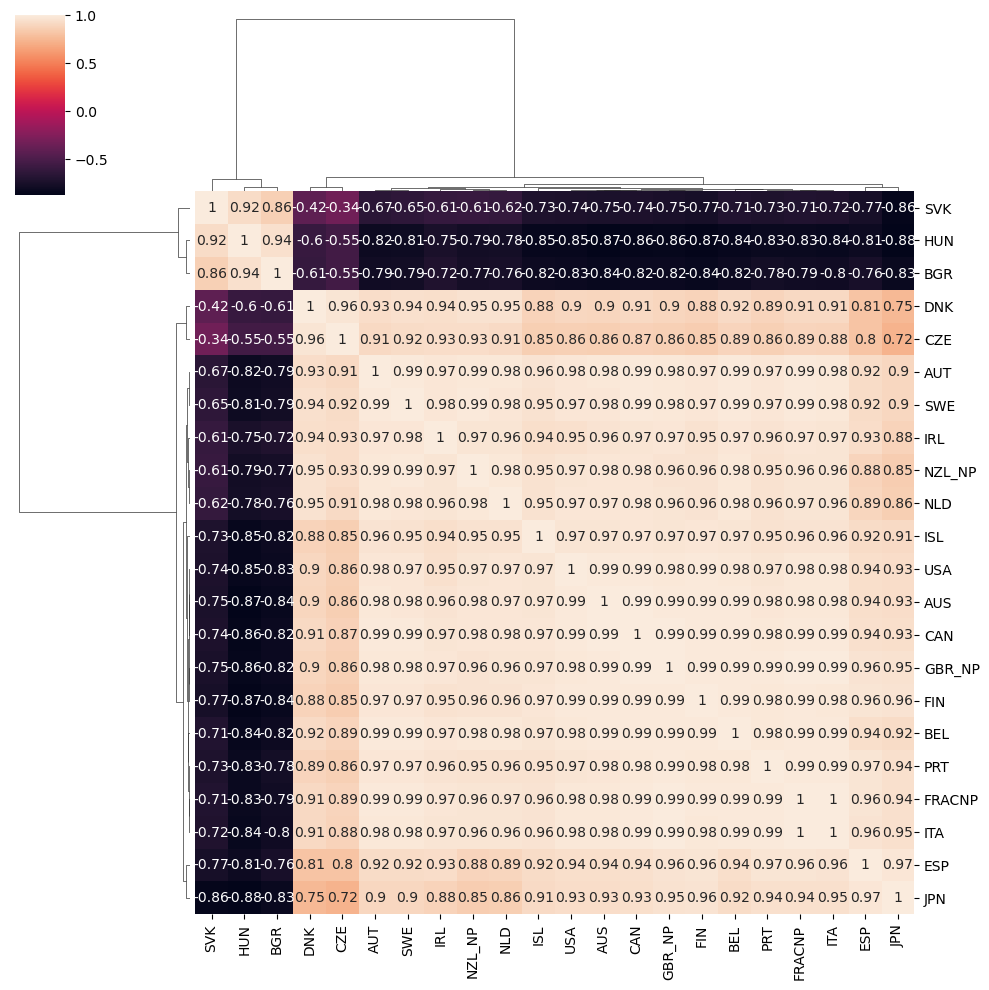

In [53]:
plt.figure(figsize= (10,8))
sns.clustermap(X_red.corr(),annot=True)

The variance explained by principal components:  [0.77904856]
The variance explained by principal components:  [0.88168075]
The variance explained by principal components:  [0.81525216]
The variance explained by principal components:  [0.87018951]
The variance explained by principal components:  [0.81828426]
The variance explained by principal components:  [0.41667104]
The variance explained by principal components:  [0.84116818]
The variance explained by principal components:  [0.68386931]
The variance explained by principal components:  [0.49195094]
The variance explained by principal components:  [0.88891196]
The variance explained by principal components:  [0.7600753]
The variance explained by principal components:  [0.55795892]
The variance explained by principal components:  [0.86340313]
The variance explained by principal components:  [0.91654784]
The variance explained by principal components:  [0.80849422]
The variance explained by principal components:  [0.83379496]
The varia

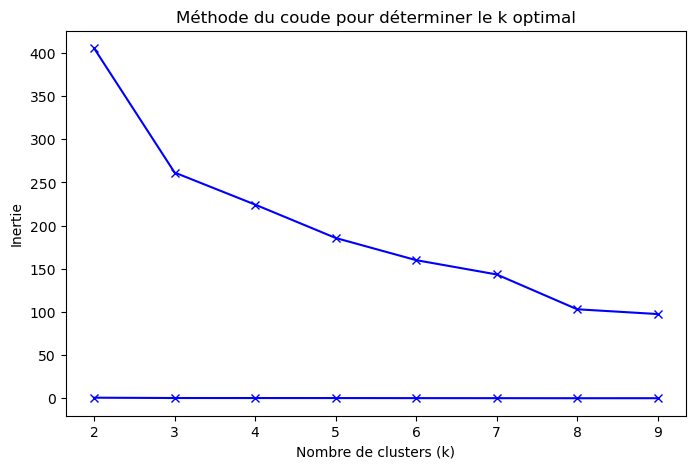

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
      dtype=int32)

In [25]:
AM.adaptative_matrix(X_norm)

## 6) Modélisation 

In [15]:
from gt_a_model import GTA_Model
from torch import optim
from sklearn.preprocessing import MinMaxScaler

In [16]:
X.shape

torch.Size([22, 61, 100])

In [18]:
model = GTA_Model(n_predictions=9)
#model = Encoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

torch.autograd.set_detect_anomaly(True)
# Boucle d'entraînement simple
for epoch in range(200):
# Zéro le gradient
    optimizer.zero_grad()

    # Forward pass
    output = model(X,A)

    # Calcul de la perte
    loss = criterion(output, test)

    # Backward pass et optimisation
    loss.backward()
    optimizer.step()

    # Affichage des informations
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')



Epoch [10/100], Loss: 141.5123
Epoch [20/100], Loss: 108.2157
Epoch [30/100], Loss: 40605757440.0000
Epoch [40/100], Loss: 2156601595133952.0000
Epoch [50/100], Loss: 111482699776.0000
Epoch [60/100], Loss: 2618463354880.0000
Epoch [70/100], Loss: 12029113925632.0000
Epoch [80/100], Loss: 40227787767808.0000
Epoch [90/100], Loss: 13654289285120.0000
Epoch [100/100], Loss: 5138072731648.0000
Epoch [110/100], Loss: 414133911552.0000
Epoch [120/100], Loss: 335823831040.0000
Epoch [130/100], Loss: 3063375616.0000
Epoch [140/100], Loss: 25169936384.0000
Epoch [150/100], Loss: 10710392832.0000
Epoch [160/100], Loss: 1755404928.0000
Epoch [170/100], Loss: 380515552.0000
Epoch [180/100], Loss: 98205328.0000
Epoch [190/100], Loss: 109387096.0000
Epoch [200/100], Loss: 59663180.0000


In [18]:
output.shape

torch.Size([22, 61, 100])

In [ ]:
x.isnan().sum()

tensor(105936)

In [ ]:
A

tensor([[0.0000e+00, 3.1061e+02, 3.1741e+02, 1.5355e+03, 3.8052e+01, 5.0000e-03,
         2.2646e+02, 4.0601e+03, 8.5495e+02, 1.5768e+02, 4.5506e+02, 8.2135e+02,
         4.8723e+03, 4.6645e+03, 4.3682e+02, 5.0000e-03, 4.7738e+02, 5.6629e+01,
         2.6496e+03, 5.0000e-03, 1.2371e+03, 9.9809e+02],
        [3.1061e+02, 0.0000e+00, 9.1326e+00, 3.1563e+02, 4.7811e+02, 5.0000e-03,
         2.8446e+02, 1.8577e+03, 9.3818e+01, 1.4747e+01, 1.8038e+01, 2.2178e+02,
         3.5972e+02, 1.3345e+04, 6.1400e+01, 5.0000e-03, 3.6593e+01, 1.8500e+02,
         5.4540e+02, 5.0000e-03, 6.0894e+02, 1.2030e+02],
        [3.1741e+02, 9.1326e+00, 0.0000e+00, 4.2388e+02, 3.9960e+02, 5.0000e-03,
         1.6635e+02, 1.8868e+03, 6.8559e+01, 6.1401e+00, 4.7618e+00, 1.5687e+02,
         5.1416e+02, 1.1549e+04, 5.2890e+01, 5.0000e-03, 2.5685e+01, 1.1005e+02,
         5.0560e+02, 5.0000e-03, 1.2148e+03, 1.5343e+02],
        [1.5355e+03, 3.1563e+02, 4.2388e+02, 0.0000e+00, 4.0160e+03, 5.0000e-03,
         1.4092e

In [ ]:
A = A + torch.eye(A.shape[0])

x=A/ A.sum(dim=-1,keepdim=True)
x.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], dtype=torch.float64)

In [ ]:
x

tensor([[4.1373e-05, 1.2851e-02, 1.3132e-02, 6.3527e-02, 1.5743e-03, 2.0686e-07,
         9.3692e-03, 1.6797e-01, 3.5371e-02, 6.5237e-03, 1.8827e-02, 3.3981e-02,
         2.0158e-01, 1.9298e-01, 1.8072e-02, 2.0686e-07, 1.9750e-02, 2.3429e-03,
         1.0962e-01, 2.0686e-07, 5.1184e-02, 4.1294e-02],
        [1.6463e-02, 5.3001e-05, 4.8404e-04, 1.6729e-02, 2.5341e-02, 2.6501e-07,
         1.5077e-02, 9.8459e-02, 4.9724e-03, 7.8160e-04, 9.5603e-04, 1.1754e-02,
         1.9065e-02, 7.0731e-01, 3.2543e-03, 2.6501e-07, 1.9395e-03, 9.8055e-03,
         2.8907e-02, 2.6501e-07, 3.2275e-02, 6.3759e-03],
        [1.8069e-02, 5.1989e-04, 5.6927e-05, 2.4130e-02, 2.2748e-02, 2.8464e-07,
         9.4696e-03, 1.0741e-01, 3.9029e-03, 3.4954e-04, 2.7108e-04, 8.9299e-03,
         2.9270e-02, 6.5746e-01, 3.0109e-03, 2.8464e-07, 1.4622e-03, 6.2646e-03,
         2.8783e-02, 2.8464e-07, 6.9154e-02, 8.7343e-03],
        [3.4673e-02, 7.1272e-03, 9.5717e-03, 2.2581e-05, 9.0686e-02, 1.1291e-07,
         3.1821e

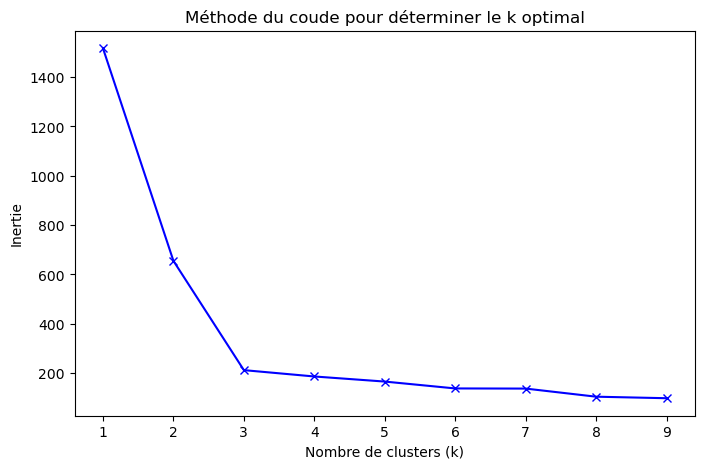

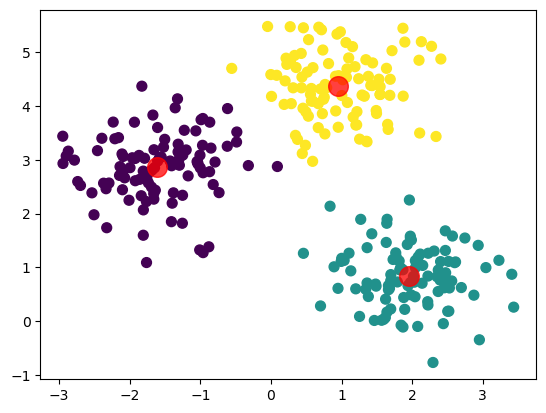

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Génération de données aléatoires avec 3 centres (clusters)
X, y = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# Méthode du coude : tester différents k et calculer l'inertie
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


# Tracer l'inertie en fonction de k pour repérer le coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le k optimal')
plt.show()

# Appliquer K-means avec le nombre optimal de clusters (ex. k=3)
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(X)

# Visualiser les clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Visualiser les centres de clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.show()


In [20]:
from sklearn.metrics import silhouette_score

# Calcul du silhouette score pour k = 3
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(X)
score = silhouette_score(X, y_kmeans)

print(f"Silhouette score pour k=3 : {score}")


Silhouette score pour k=3 : 0.6594056994076228


In [22]:
silhouette_score(X, y_kmeans)

0.6594056994076228